#### **Automated Event Detection and Coupling Pipeline Tutorial**

This document introduces a PSG event detection and coupling pipeline that includes the automated detection for slow oscillations and sleep spindles using various customizable methods and parameters. It also supports phase-amplitude coupling analysis of detected events.

The standardized procedure includes the following steps:

  - 1. Read preprocessed EEG files and corresponding scoring files

  - 2. Detect slow oscillation and sleep spindle events during each sleep stage using selected methods

  - 3. (Optional) Time-lock each sleep spindle event whose maximum instantaneous amplitude falls within ±1.5 s (default) of an SO trough as a coupling event.

  - 4. (Optional) Perform phase-amplitude coupling analysis and generate a table of oscillation and coupling metrics for group-level analysis.

  - 5. (Optional) Visualize detected events and group-level results

In [1]:
# ----------------- Load packages ------------------- #
import os
import contextlib
import io
import numpy as np
import pandas as pd
import mne
import seaborn as sns
from scipy.io import loadmat
from AutoPSG import *
from AutoPSG.artifact_detect import load_raw, load_hypnogram_data, good_epoch_dur, hypnogram_segment
from AutoPSG.event_detect import SO_detection, plot_SO, SP_detection, plot_SP, event_lock, compute_pac_metrics, pac, pac_grp

**Standardized Event detection (and coupling) precedures:**

Before event detection, you should have two subfolders within the main folder (your may change to other names):
   - "preproc" to store preprocessed PSG files.
   - "scoring" to store sleep stage scoring files. It currently only supports mat. file; txt. and csv. file types will soon be supported.
     - Each scoring file should contain sleep stages scored by 30s, with 0 = Wake, 1 = N1, 2 = N2, 3 = SWS, and 4 = REM.

The data structure before event detection should be similar to:

- data
  - preproc ()
    - PSG_01_wordtask.fif
    - PSG_02_wordtask.fif
    - ...
  - scoring
    - PSG_01_wordtask.mat
    - PSG_02_wordtask.mat
    - ...

1. Load preprocessed EEG raw data and sleep stage scoring file
2. Set parameters and other options used for the event detection
3. Run!

We **strongly encourage** users to reference the raw data to the contralateral mastoids (M1 and M2) before event detection.

It is the default setting if you use our preprocessing pipeline. Average reference may cause distortion.

There are six slow oscillation detection methods available:
1. Staresina, use percentile threshold: top 25% PTP
2. Ng, use adjusted percentile threshold: top 30% PTP & top 30% trough
3. Massimini, (and Dang-Vu) use absolute threshold: trough < -80µv & trough-to-peak > 140µv
4. Dimulescu, use adjusted absolute threshold: trough < -40µv & trough-to-peak > 70µv
5. Molle, use relative threshold: trough > 2/3 mean trough & event PTP > 2/3 mean PTP
6. Ngo, use adjusted relative threshold: trough > 1.25 mean trough & event PTP > 1.25 mean PTP

There are five sleep spindle detection methods available:
1. Hahn2020: Bandpass filter: 12–16 Hz, Uses Hilbert transform and a smoothed amplitude envelope, top 25% amplitude.
2. Martin2013: Bandpass filter: 11–15 Hz, Root mean square (RMS) envelope with a 250 ms window, 95th percentile of RMS values.
3. Wamsley2012: Wavelet-based approach, time-frequency transform using a Morlet wavelet.
    Rectified moving average of the wavelet signal with a 100 ms window. Threshold: 4.5 times the mean amplitude.
4. Wendt2012: Bandpass filter: 11–16 Hz using equiripple filters,
    Dual detectors with time-varying thresholds (3 μV and 8 μV offsets).
5. Ferrarelli2007: Bandpass filter: 12–15 Hz,
    Rectified signal; thresholds based on 2x (lower) and 8x (upper) the mean amplitude. Boundaries defined by crossings of thresholds.

Start event detection for subject EMO102_N.
Detected SOs in stage SWS
Method: Ng
PTP amplitude: 187.0311
Mean Duration: 1.3106
SO Density per 30s: 3.3118
Total Count: 12022
---------------------------------------------------------------
Detected SPs in stage SWS
Method: Hahn2020
Average Amplitude: 15.9829 uv
Average Duration: 0.8944s
Spindle Density (per 30s): 5.6388
Total Spindle Count: 20469
---------------------------------------------------------------
Spindles coupled with SOs in stage SWS: 43.65%
SOs coupled with spindles in stage SWS: 74.31%


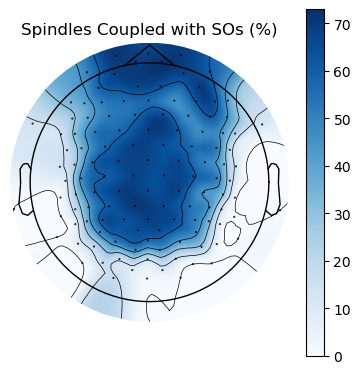

Stage SWS:
Preferred Phase:       -0.415 rad
Modulation Index:      0.008
Mean Vector Length:    0.131
Rayleigh z:            130.975
p-value:               0.000
Coupling Density:      2.612


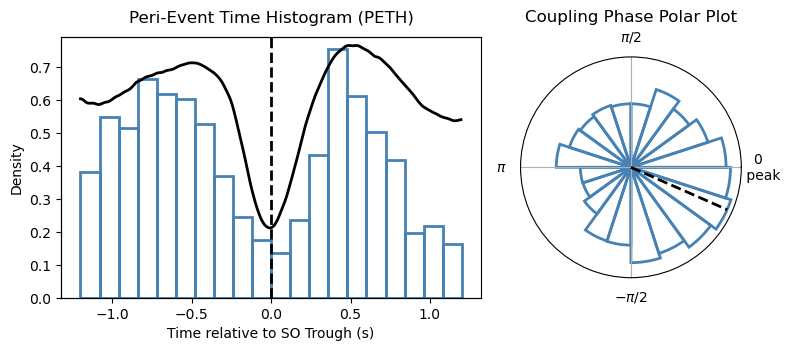

Start event detection for subject EMO104_N.
Detected SOs in stage SWS
Method: Ng
PTP amplitude: 118.4244
Mean Duration: 1.1866
SO Density per 30s: 3.9558
Total Count: 12445
---------------------------------------------------------------
Detected SPs in stage SWS
Method: Hahn2020
Average Amplitude: 7.8593 uv
Average Duration: 0.7626s
Spindle Density (per 30s): 3.8373
Total Spindle Count: 12072
---------------------------------------------------------------
Spindles coupled with SOs in stage SWS: 48.80%
SOs coupled with spindles in stage SWS: 47.34%


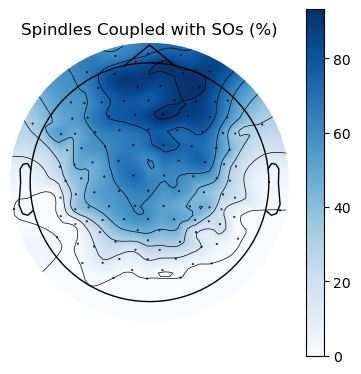

Stage SWS:
Preferred Phase:       -0.061 rad
Modulation Index:      0.007
Mean Vector Length:    0.106
Rayleigh z:            56.462
p-value:               0.000
Coupling Density:      1.953


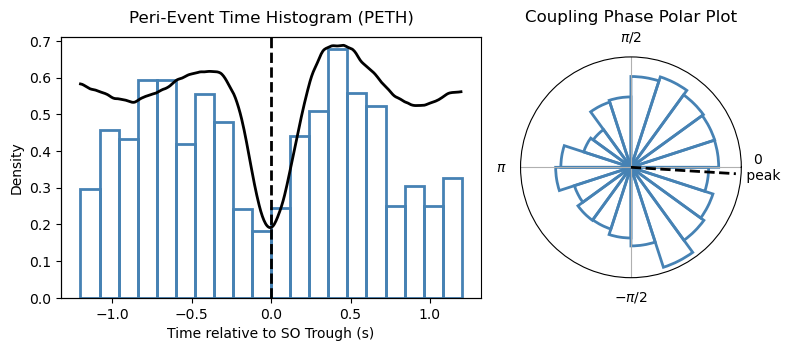

In [ ]:
##################################### Parameter Settings for the Pipeline ######################################
os.chdir('/Users/somneuro/Desktop/PSG/data')
processed_file = 'preproc/'
scoring_file = 'scoring/'
interest_stage = ['N2', 'SWS'] # Only detect events in selected stages. Available inputs: Wake, N1, N2, SWS, REM
rerefer = False # Set to True if reference channels are not contralateral mostoids or you are unsure
scoring_dur = 30 # (in seconds) the duration of each epoch used for sleep scoring
chan_limit = None # Use None to detect events in all channels, or use ['Fz', 'Cz', ...] to detect in selected channels only.
baseline_correct = True # Baseline correction before event detection
verbose = True # Enable diagnostic plots and printings
coupling = True # Perform phase-amplitude coupling analysis after event detection

###################################### Automated Event Detection Pipeline ######################################
## DO NOT CHANGE THE FOLLOWING CODE IF YOU DO NOT PLAN TO MODIFY, DEBUG, OR CUSTOMIZE THE EVENT DETECTION STEPS
file_paths = [os.path.join(processed_file, f) for f in os.listdir(processed_file) if f.endswith(('.vhdr', '.edf', '.fif', '.set', '.fdt', '.bdf', '.cnt'))]
coupling_event_all = []
event_summary_all = []
SO_waveform_all = []

for file_path in file_paths:
    id = os.path.splitext(os.path.basename(file_path))[0]
    print(f"\033[1mStart event detection for subject {id}.\033[0m")
    raw = load_raw(file_path)
    if chan_limit is not None:
        raw = raw.pick_channels(raw.info["ch_names"], include=chan_limit)
    if rerefer:
        raw.set_eeg_reference(ref_channels=['M1', 'M2'])
    stage = hypnogram_segment(raw=raw, interval=scoring_dur, file_paths=os.path.join(scoring_file, f"{id}.mat"))

    _, SO_candidate, SO_summary = SO_detection(raw, stage, interest_stage, method='Ng', baseline=baseline_correct, verbose=verbose)
    _, SP_candidate, SP_summary = SP_detection(raw, stage, interest_stage, method="Hahn2020", baseline=baseline_correct, verbose=verbose)
    event_summary = pd.merge(SO_summary, SP_summary, on=['stage'], how='outer')
    event_summary.insert(0, 'subject', id)

    if coupling:
        cp_event, event_summary = event_lock(raw, SO_candidate, SP_candidate, event_summary, verbose=verbose)
        cp_event.insert(0, 'subject', id)
        coupling_event_all.append(cp_event)
        event_summary, SO_waveform = pac(raw, cp_event, event_summary, verbose=verbose)
        SO_waveform_all.append(SO_waveform)
    event_summary_all.append(event_summary)

event_summary_grp = pd.concat(event_summary_all, ignore_index=True)
if coupling:
    cp_event_grp = pd.concat(coupling_event_all, ignore_index=True)
    SO_waveform_grp = pd.concat(SO_waveform_all, ignore_index=True)

The pipeline above returns three dataframes: cp_event_grp, event_summary_grp, and SO_waveform_grp.

- **event_summary_grp** contains key variables used in modern sleep analysis per channel, sleep stage, and subject, including: 
    - individual oscillation metrics: amplitude, density, duration
    - coupling metrics: phase, strength (mean vector length and modulation index), density, percentage)
    This dataframe can be used to correlate with individual behavioral data or compare between channels, sleep stages, and population groups.
- **cp_event_grp** provides the timing of each coupling event, categorized by channel, sleep stage, and subject.
- **SO_waveform_grp** stores the amplitude data of each detected SO, for visualization purposes only.

Here is what the "event_summary_grp" dataframe looks like:

In [9]:
col_names = event_summary_grp.columns.tolist()
for i in range(0, len(col_names), 9):
    print(col_names[i:i+9])

['subject', 'stage', 'channel', 'stage_dur', 'mean_SO_amp', 'mean_SO_dur', 'SO_density', 'mean_SP_amp', 'mean_SP_dur']
['SP_density', 'SPcSO', 'SOcSP', 'preferred_phase', 'modulation_index', 'mean_vector_length', 'rayleigh_z', 'coupling_density']


Here are some simple examples to play with outputs saved in event_summary_grp table:

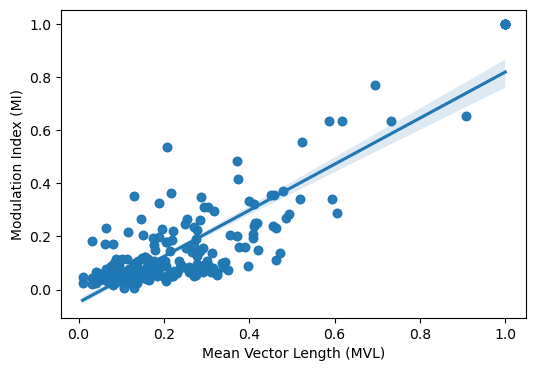

In [ ]:
plt.figure(figsize=(6, 4))
sns.regplot(x=event_summary_grp['mean_vector_length'], 
            y=event_summary_grp['modulation_index'])
plt.xlabel('Mean Vector Length (MVL)')
plt.ylabel('Modulation Index (MI)')
plt.show()

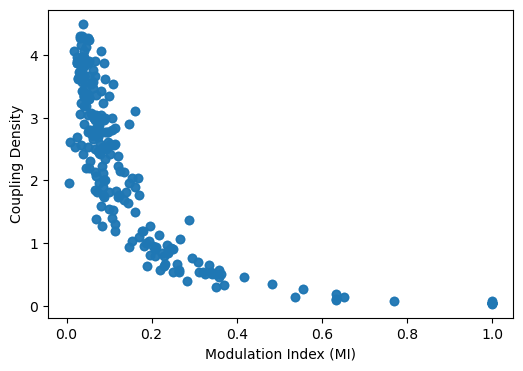

In [20]:
plt.figure(figsize=(6, 4))
sns.regplot(x=event_summary_grp['modulation_index'], 
            y=event_summary_grp['coupling_density'],
            fit_reg=False)
plt.xlabel('Modulation Index (MI)')
plt.ylabel('Coupling Density')
plt.show()

Oh this one is funny! Does it really mean that a channel with a lower coupling density tend to have a stronger coupling strength? (No) Your turn to explain.

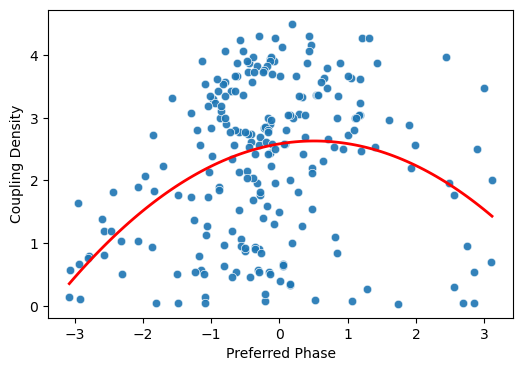

In [32]:
x = event_summary_grp['preferred_phase']
y = event_summary_grp['coupling_density']
mask = np.isfinite(x) & np.isfinite(y)
x, y = x[mask], y[mask]
coeffs = np.polyfit(x, y, 2)
poly_eq = np.poly1d(coeffs)
x_fit = np.linspace(x.min(), x.max(), 100)
y_fit = poly_eq(x_fit)

plt.figure(figsize=(6, 4))
sns.scatterplot(x=x, y=y, alpha=0.7)
plt.plot(x_fit, y_fit, color='red', linewidth=2)
plt.xlabel('Preferred Phase')
plt.ylabel('Coupling Density')
plt.show()

Pretty significant-- How would you interpret it? Recall that 0 means SO peak.

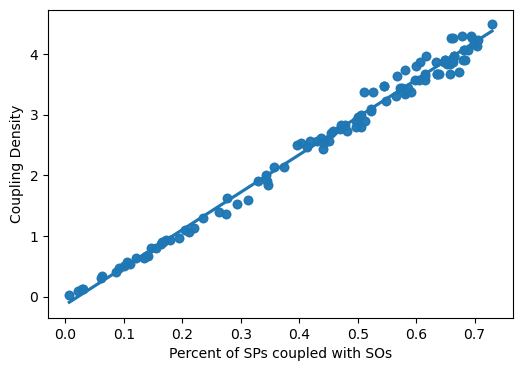

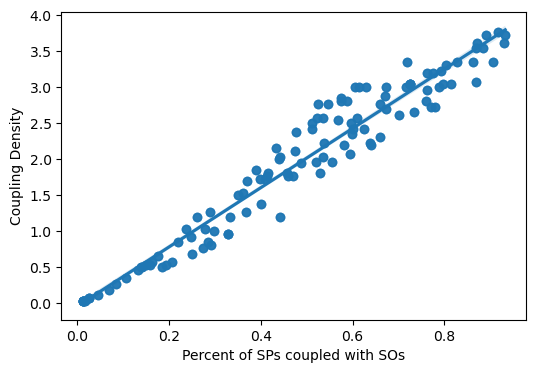

In [8]:
unique_subj = event_summary_grp['subject'].unique()

for subj in unique_subj:
    subset = event_summary_grp[event_summary_grp['subject'] == subj]
    plt.figure(figsize=(6, 4))
    sns.regplot(x=subset["SPcSO"], y=subset['coupling_density'])
    plt.xlabel('Percent of SPs coupled with SOs')
    plt.ylabel('Coupling Density')
    plt.show()

Magic! Super strong linear correlation.

You can also visually examine detected events to determine which method works best for your data:

In [ ]:
plot_SO(SO_candidate, raw, grp_thres=0.3, sync_trough=False, interact=False, multilayer=False)
plot_SP(SP_candidate, raw, grp_thres=0.3, sync_peak=False, interact=False, multilayer=False)

**Group-level analysis**

The following code can be used to generate a group-level coupling plot, which includes:

- A peri-event time histogram (PETH) that shows the frequency of sleep spindles locked to each slow oscillation phase superimposed with a SO waveform (black), with a cluster-based permutation test. Significant clusters are marked by red dots. Average of shuffled data is plotted in gray.

- A circular plot displaying the preferred phase for each subject (blue dots), along with a mean vector length indicator (black line) representing phase consistency. The length ranges from 0 (weak) to 1 (strong, reaching the circumference).

It is possible to plot data for either a single sleep stage (e.g., set stage='SWS') or for all stages averaged (stage='all'). 
Also, you can compute results using selected channels (e.g., set chan=['C3', 'C4']) or average across all channels (chan='all').

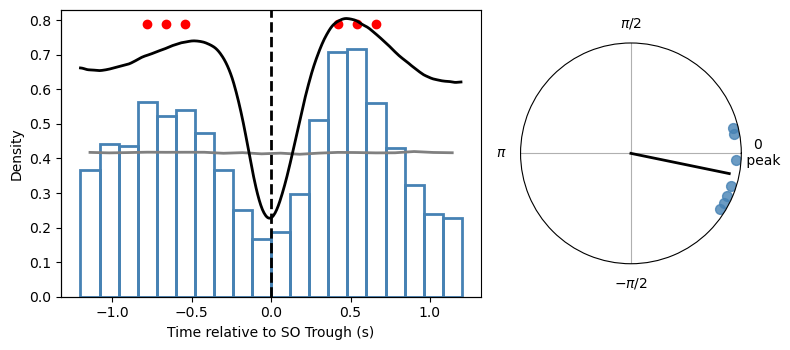

In [ ]:
pac_grp(raw, cp_event_grp, event_summary_grp, SO_waveform_grp, stage='SWS', chan='all')

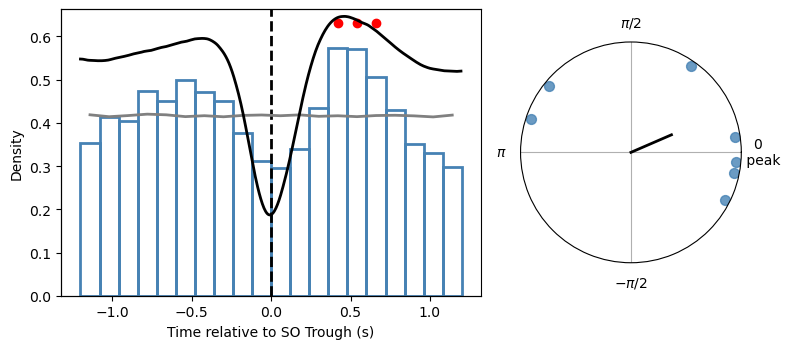

In [40]:
pac_grp(raw, cp_event_grp, event_summary_grp, SO_waveform_grp, stage='all', chan='all')

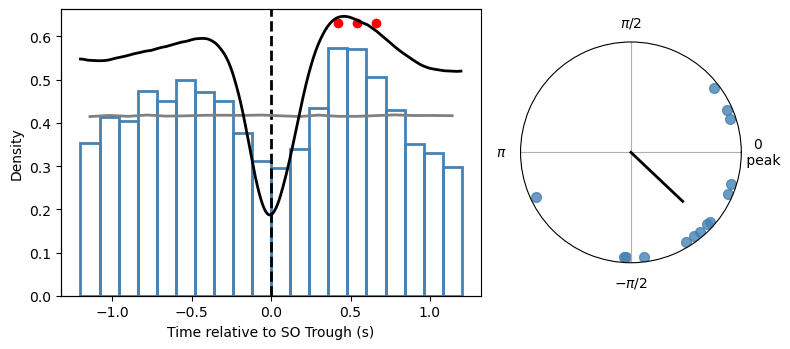

In [46]:
pac_grp(raw, cp_event_grp, event_summary_grp, SO_waveform_grp, stage='all', chan=['P3', 'P4'])

**Helper function: customized event detection**

- Instead of directly use pre-specified parameters in listed methods, you can choose to set your own parameters for event detection with the following code.

In [ ]:
SO_detection(raw, stage, interest_stage, filter_freq=None, duration=None, filter_type='fir', method='Staresina', baseline=True)
SP_detection(raw, stage, interest_stage, l_freq=None, h_freq=None, dur_lower=None, dur_upper=None, method="Hahn2020", baseline=True)

**Potential features for next version:**

1. Time-Frequency Representation (TFR) Analysis
2. Customizable frequency range for spindle detection based on spectral analysis (now users can manually pass values in functions)
3. Visualization of coupled oscillations

Some more data wrangling if you are interested in ... (two subjects plotted separately)

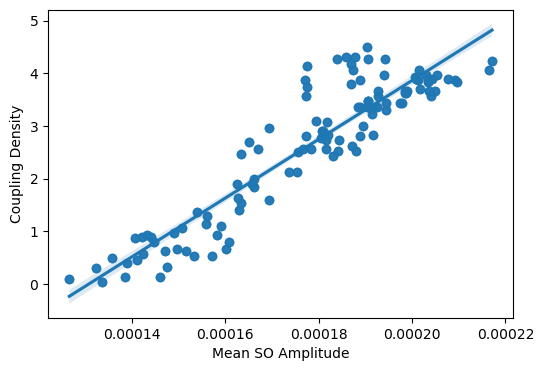

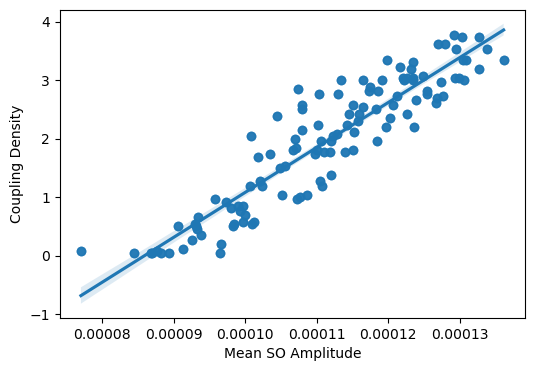

In [12]:
unique_subj = event_summary_grp['subject'].unique()

for subj in unique_subj:
    subset = event_summary_grp[event_summary_grp['subject'] == subj]
    plt.figure(figsize=(6, 4))
    sns.regplot(x=subset['mean_SO_amp'], y=subset['coupling_density'])
    plt.xlabel('Mean SO Amplitude')
    plt.ylabel('Coupling Density')
    plt.show()

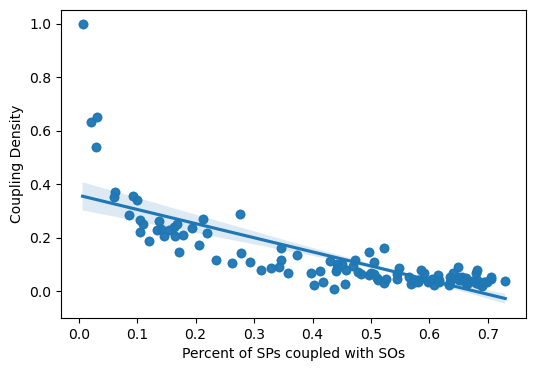

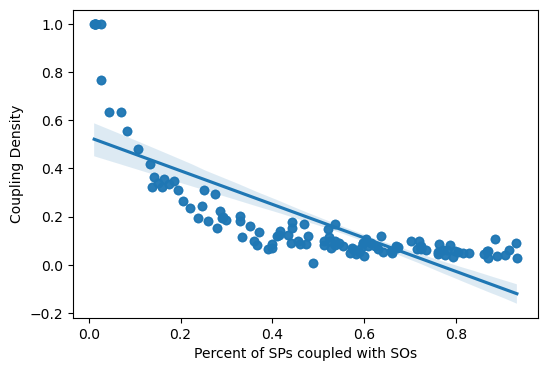

In [7]:
unique_subj = event_summary_grp['subject'].unique()

for subj in unique_subj:
    subset = event_summary_grp[event_summary_grp['subject'] == subj]
    plt.figure(figsize=(6, 4))
    sns.regplot(x=subset["SPcSO"], y=subset['modulation_index'])
    plt.xlabel('Percent of SPs coupled with SOs')
    plt.ylabel('Coupling Density')
    plt.show()

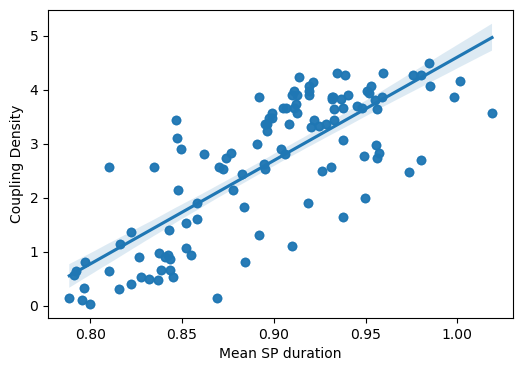

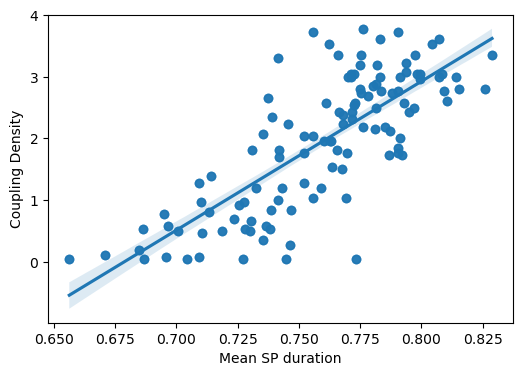

In [6]:
unique_subj = event_summary_grp['subject'].unique()

for subj in unique_subj:
    subset = event_summary_grp[event_summary_grp['subject'] == subj]
    plt.figure(figsize=(6, 4))
    sns.regplot(x=subset["mean_SP_dur"], y=subset['coupling_density'])
    plt.xlabel('Mean SP duration')
    plt.ylabel('Coupling Density')
    plt.show()

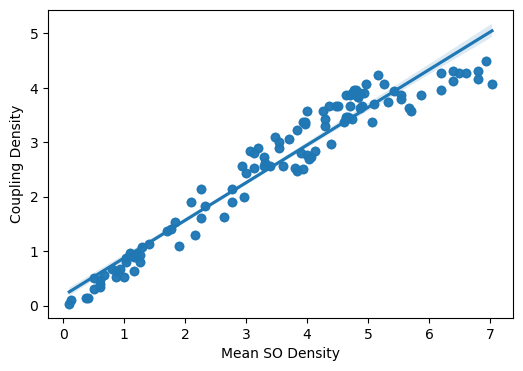

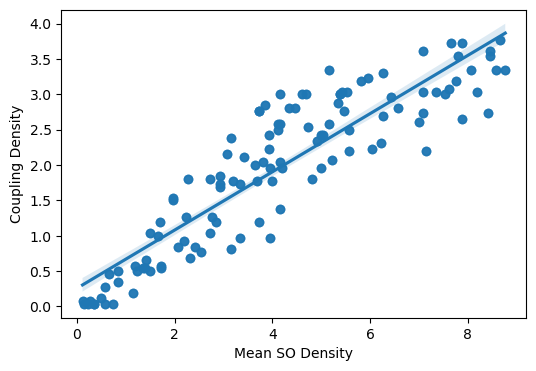

In [17]:
unique_subj = event_summary_grp['subject'].unique()

for subj in unique_subj:
    subset = event_summary_grp[event_summary_grp['subject'] == subj]
    plt.figure(figsize=(6, 4))
    sns.regplot(x=subset["SO_density"], y=subset['coupling_density'])
    plt.xlabel('Mean SO Density')
    plt.ylabel('Coupling Density')
    plt.show()

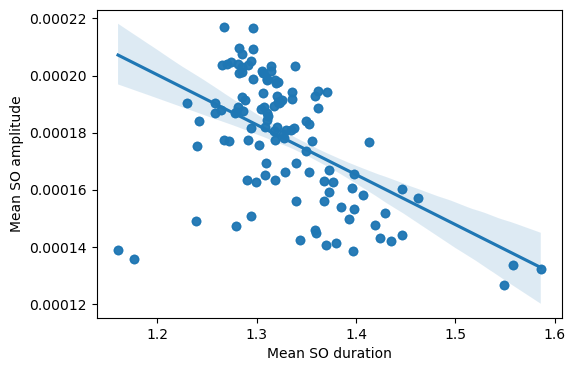

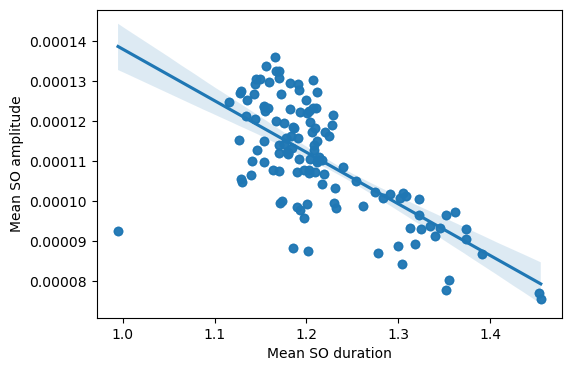

In [12]:
unique_subj = event_summary_grp['subject'].unique()

for subj in unique_subj:
    subset = event_summary_grp[event_summary_grp['subject'] == subj]
    plt.figure(figsize=(6, 4))
    sns.regplot(x=subset["mean_SO_dur"], y=subset['mean_SO_amp'])
    plt.xlabel('Mean SO duration')
    plt.ylabel('Mean SO amplitude')
    plt.show()

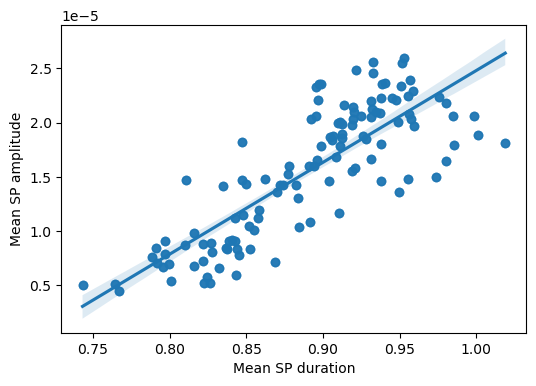

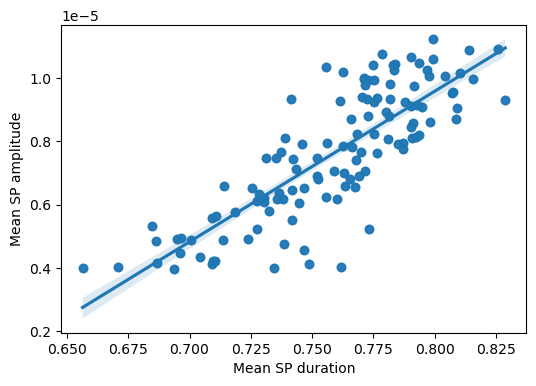

In [13]:
unique_subj = event_summary_grp['subject'].unique()

for subj in unique_subj:
    subset = event_summary_grp[event_summary_grp['subject'] == subj]
    plt.figure(figsize=(6, 4))
    sns.regplot(x=subset["mean_SP_dur"], y=subset['mean_SP_amp'])
    plt.xlabel('Mean SP duration')
    plt.ylabel('Mean SP amplitude')
    plt.show()

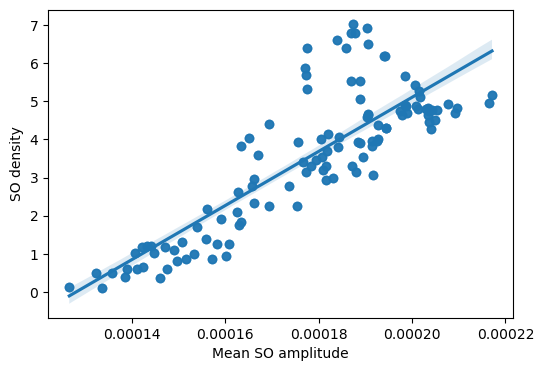

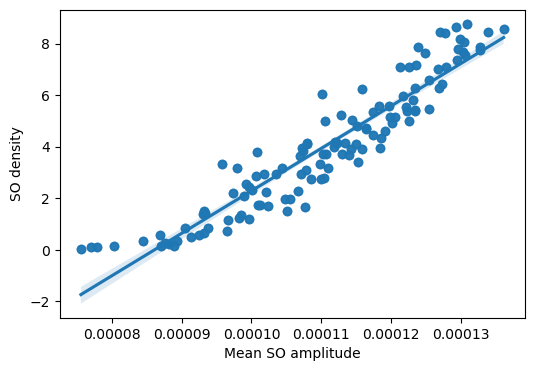

In [17]:
unique_subj = event_summary_grp['subject'].unique()

for subj in unique_subj:
    subset = event_summary_grp[event_summary_grp['subject'] == subj]
    plt.figure(figsize=(6, 4))
    sns.regplot(x=subset["mean_SO_amp"], y=subset['SO_density'])
    plt.xlabel('Mean SO amplitude')
    plt.ylabel('SO density')
    plt.show()